## Purpose
This notebook imports images and their labels from the ai_club team folder and exports the images, cropped to their ROI.


In [13]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imagesize
from PIL import Image, ImageFilter

In [5]:
# define input folders
source_folder = '/data/ai_club/team_13_2024-25/VIPR/Data'
images_folder = os.path.join(source_folder,'YOLO_images_total')
labels_folder = os.path.join(source_folder,'YOLO_labels_total')
cropped_folder = os.path.join(source_folder,'ROI_cropped_images')
output_folder = 'ROI_cropped_images'

In [3]:
# create output folder
try:
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
except OSError:
    print('Error creating data directory.')

In [6]:
image_list = os.listdir(images_folder)
label_list = os.listdir(labels_folder)
cropped_list = os.listdir(cropped_folder)

image_path_list = [os.path.join(images_folder,image) for image in os.listdir(images_folder)]
label_path_list = [os.path.join(labels_folder,label) for label in os.listdir(labels_folder)]

In [105]:
def blend_halves_bilinear(left_img, right_img, blend_width=10):
    """
    Combine left_img and right_img without removing any pixels in the overlapping region.
    The overlapping seam is defined as the rightmost blend_width columns of left_img and
    the leftmost blend_width columns of right_img. These two regions are first resampled
    using bilinear interpolation to a common width (2*blend_width), then blended together
    with a 2D alpha mask that transitions smoothly from 0 (left image) to 1 (right image).
    """
    width_left, height = left_img.size
    width_right, _ = right_img.size

    # Create composite image: paste left_img fully, then right_img fully shifted.
    total_width = width_left + width_right
    composite = Image.new(left_img.mode, (total_width, height))
    composite.paste(left_img, (0, 0))
    composite.paste(right_img, (width_left, 0))

    # Define the seam region in the composite:
    seam_start = width_left - blend_width  # start of overlap in composite
    seam_width = 2 * blend_width            # full width of overlap region

    # Extract the overlapping regions:
    left_overlap = left_img.crop((width_left - blend_width, 0, width_left, height))
    right_overlap = right_img.crop((0, 0, blend_width, height))

    # Resample each overlap to a common region of width = 2*blend_width using bilinear interpolation.
    left_resized = left_overlap.resize((seam_width, height), resample=Image.Resampling.BILINEAR)
    right_resized = right_overlap.resize((seam_width, height), resample=Image.Resampling.BILINEAR)

    # Convert to numpy arrays (float32 for interpolation math)
    left_arr = np.array(left_resized, dtype=np.float32)
    right_arr = np.array(right_resized, dtype=np.float32)

    # Create a 2D alpha mask for blending.
    # Here the mask is purely horizontal—every row gets the same gradient from 0 (left) to 1 (right).
    # (If desired you could incorporate a vertical component too.)
    alpha = np.tile(np.linspace(0, 1, seam_width), (height, 1))
    
    # Blend the two resampled overlap regions using the alpha mask.
    # For each pixel: blended = (1 - alpha) * left_pixel + alpha * right_pixel.
    blended_region = (1 - alpha)[..., None] * left_arr + alpha[..., None] * right_arr

    # Convert back to a PIL Image.
    blended_region_img = Image.fromarray(np.clip(blended_region, 0, 255).astype(np.uint8), mode=left_img.mode)
    
    # Paste the blended seam back into the composite image.
    composite.paste(blended_region_img, (seam_start, 0))

    return composite

In [53]:
def blend_halves(left_img, right_img, blend_width=10):
    """
    Combine left_img and right_img (which are meant to overlap)
    without removing any pixels. The overlapping seam spans 2*blend_width columns,
    where we blend the last blend_width columns of left_img with the first blend_width columns of right_img.
    """
    width_left, height = left_img.size
    width_right, _ = right_img.size

    # Create a new image that contains both halves in full.
    total_width = width_left + width_right
    composite = Image.new(left_img.mode, (total_width, height))
    composite.paste(left_img, (0, 0))
    composite.paste(right_img, (width_left, 0))

    # Define the seam region: from (width_left - blend_width) to (width_left + blend_width)
    seam_start = width_left - blend_width
    seam_end   = width_left + blend_width

    # Blend each column in the seam region.
    for i in range(seam_end - seam_start):
        # i goes from 0 to (2*blend_width - 1)
        # Compute alpha: 0 at the left edge of the seam, 1 at the right edge.
        alpha = i / float((2 * blend_width) - 1)
        x = seam_start + i

        # For the left image, if x is within its domain, take that column.
        if x < width_left:
            left_col = left_img.crop((x, 0, x+1, height))
        else:
            # For x beyond the left image, use the last column of left_img.
            left_col = left_img.crop((width_left-1, 0, width_left, height))

        # For the right image, map x into its coordinate system.
        right_x = x - width_left
        if 0 <= right_x < blend_width:
            right_col = right_img.crop((right_x, 0, right_x+1, height))
        else:
            # For x outside the intended overlap in right_img, use its first column.
            right_col = right_img.crop((0, 0, 1, height))

        # Compute the blended column.
        blended_col = Image.blend(left_col, right_col, alpha)
        # Paste the blended column back into the composite image.
        composite.paste(blended_col, (x, 0))

    return composite

# Example usage:
# left_img and right_img are PIL Image objects representing the two halves.
# blended_image = blend_halves_preserve_overlap(left_half_str, right_half_ext, blend_width=10)

In [106]:
def crop_and_stretch(image_path, label_path, scaleFactor=1.2, blend_width=10):
    """Crops a 256x256 image to the region of interest (ROI) specified by the label file and resizes it back to 256x256."""
    # Verify that the image and label file have matching base names.
    image_base = os.path.splitext(os.path.basename(image_path))[0]
    label_base = os.path.splitext(os.path.basename(label_path))[0]
    if image_base != label_base:
        raise ValueError("Image file and label file names do not match.")

    # Open the image.
    image = Image.open(image_path)
    if image.size != (256, 256):
        raise ValueError("The input image is not 256x256 in size.")

    # Read and parse the label file.
    with open(label_path, 'r') as f:
        line = f.readline().strip()
        parts = line.split()
        if len(parts) != 5:
            raise ValueError("Label file does not contain exactly 5 values.")
        # Parse values: ignoring the first value which represents the class label.
        try:
            _, x_center, y_center, box_width, box_height = parts
            x_center = float(x_center)
            y_center = float(y_center)
            box_width = float(box_width)
            box_height = float(box_height)
        except ValueError:
            raise ValueError("One or more of the coordinate values are not valid floats.")

    # Calculate pixel coordinates for cropping.
    img_width, img_height = image.size
    left   = int((x_center - box_width / 2) * img_width)
    top    = int((y_center - box_height / 2) * img_height)
    right  = int((x_center + box_width / 2) * img_width)
    bottom = int((y_center + box_height / 2) * img_height)
    bottom_stretched = int((y_center + (box_height*scaleFactor) / 2) * img_height)
    mid = int(x_center * img_width)
    
    # Ensure coordinates are within image boundaries.
    left = max(0, left)
    top = max(0, top)
    right = min(img_width, right)
    bottom = min(img_height, bottom)
    bottom_stretched = min(img_height, bottom_stretched)
    stretched_height = bottom_stretched - top

    # Crop the image to the region of interest.
    cropped_image = image.crop((left, top, right, bottom))
    
    # Split image into left and right halves
    left_half = image.crop((left,top,mid,bottom))
    right_half = image.crop((mid,top,right,bottom))
    
    # Create extended halves
    left_half_ext = image.crop((left,top,mid,bottom_stretched))
    right_half_ext = image.crop((mid,top,right,bottom_stretched))
    
    # Create "stretched" halves
    left_half_str = left_half.resize((left_half.size[0],stretched_height), Image.Resampling.LANCZOS)
    right_half_str = right_half.resize((right_half.size[0],stretched_height), Image.Resampling.LANCZOS)
    
    # Resize healthy cropped image back to 256x256 using a high-quality filter.
    healthy = cropped_image.resize((256, 256), Image.Resampling.LANCZOS)
    
    # Create Extended reference image
    extended = Image.new(image.mode, (cropped_image.size[0], stretched_height))
    extended.paste(left_half_ext,(0,0))
    extended.paste(right_half_ext,(left_half_ext.size[0],0))
    
#     # Reconstruct left paralyzed image
#     left_par = Image.new(image.mode, (left_half_str.size[0] + right_half_ext.size[0], stretched_height))
#     left_par.paste(left_half_str, (0,0))
#     left_par.paste(right_half_ext,(left_half_str.size[0],0))
#     left_par = left_par.resize((256, 256), Image.Resampling.LANCZOS)

    # Reconstruct left paralyzed image
    left_par = blend_halves_bilinear(left_half_str, right_half_ext, blend_width)
    left_par = left_par.resize((256, 256), Image.Resampling.LANCZOS)

#     # Reconstruct right paralyzed image
#     right_par = Image.new(image.mode, (left_half_ext.size[0] + right_half_str.size[0], stretched_height))
#     right_par.paste(left_half_ext, (0,0))
#     right_par.paste(right_half_str,(left_half_ext.size[0],0))
#     right_par = right_par.resize((256, 256), Image.Resampling.LANCZOS)
    
    # Reconstruct right paralyzed image
    right_par = blend_halves_bilinear(left_half_ext, right_half_str, blend_width)
    right_par = right_par.resize((256, 256), Image.Resampling.LANCZOS)
    

    return healthy, left_par, right_par, extended

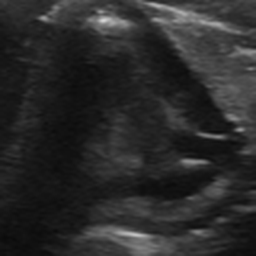

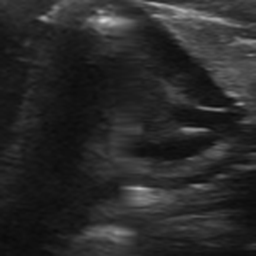

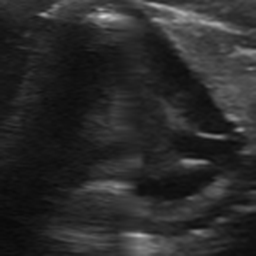

In [122]:
i = 20
scaleFactor = 1.5
blend_width = 4
[healthy, left_par, right_par, extended] = crop_and_stretch(os.path.join(images_folder,image_list[i]), os.path.join(labels_folder,label_list[i]), scaleFactor, blend_width)

healthy.show()
# extended.show()
left_par.show()
right_par.show()

In [99]:
left_par.save('leftpar.png', format="PNG")
right_par.save('rightpar.png', format="PNG")
healthy.save('healthy.png', format="PNG")

In [35]:
extended.save('extended.png', format="PNG")